In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
typo='Tlds'
df = pd.HDFStore(f'corrections_6206_{typo}.h5')['/edf']

In [4]:
df.head()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,384,0,0,48,1061,2,8883,1531471724311,433.176392,406.697400,...,-9.648212,-13.917959,262.079224,19941.156250,419597.562500,-9.394417,-13.688916,262.164942,22040.014934,394442.354935
1,384,1,0,10,20,4,67,1531471724311,433.176392,406.697400,...,-39.055331,-30.612120,305.511353,195.381104,7778.804688,-39.026492,-30.474672,305.510035,212.437059,7304.001721
2,384,2,0,13,33,6,150,1531471724311,433.176392,406.697400,...,-61.633434,-57.080638,320.785065,317.850525,14371.033203,-60.737801,-56.221812,320.773750,355.127958,14106.752602
3,1344,0,0,8,19,3,48,1531471743241,424.126648,514.047851,...,-87.526983,45.311219,138.393799,249.593460,7432.148926,-87.512733,45.332049,138.395217,258.141494,7091.100752
4,1344,1,0,51,909,4,7814,1531471743241,424.126648,514.047851,...,-89.054323,90.803363,173.918640,20306.777344,378937.562500,-89.223446,91.714983,174.627691,22466.153834,400061.007562


In [5]:
df.tail()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
8,13633558,0,127,99,916,5,9347,1531739839542,393.933502,495.087985,...,-76.783205,-6.801805,211.548141,19536.037109,426100.18750,-76.637944,-6.344770,211.925202,20570.605850,396905.206916
9,13636536,0,127,54,1047,5,9147,1531739897285,455.127167,332.503465,...,-76.849891,13.958260,338.700439,20762.361328,426417.43750,-76.623304,14.485430,338.832775,23805.654815,424293.348125
10,13636786,0,127,81,823,3,8136,1531739902447,359.733643,522.242842,...,-54.125761,112.627383,157.934692,18746.472656,372097.28125,-54.207736,112.765984,158.315658,20614.954861,390141.659337
11,13637766,0,127,76,828,3,9083,1531739921513,390.003387,555.809572,...,116.154727,27.485457,125.022446,20798.333984,420561.31250,116.475277,27.686344,126.075766,23404.781069,429413.338999
12,13640846,0,127,52,1076,4,8053,1531739981371,485.941864,355.846616,...,80.309217,58.029066,320.996552,19403.253906,389527.78125,80.496642,58.319901,320.996597,24365.106493,419012.164837


# 2. ENERGY

## 2.1 Overview

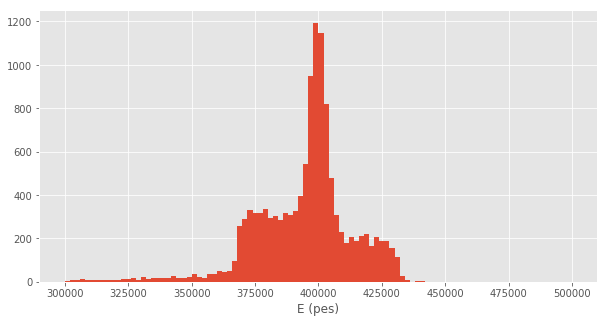

In [6]:
Emax = 500e3
Emin = 300e3

df['e'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

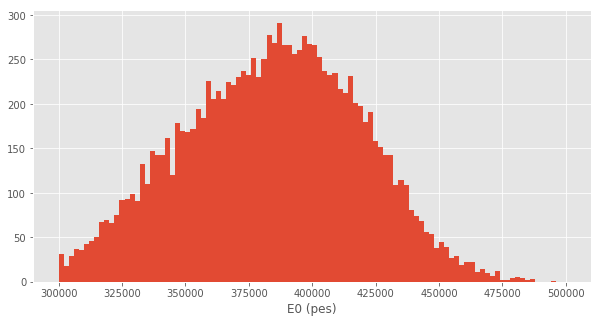

In [7]:
df['e0'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E0 (pes)', fontsize=12);

/home/gonzalo/anaconda3/envs/IC-3.7-2018-10-20/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gonzalo/anaconda3/envs/IC-3.7-2018-10-20/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


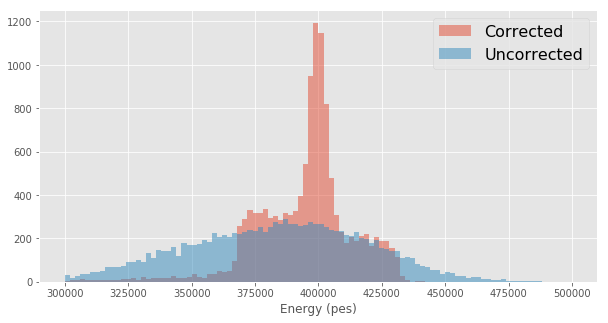

In [8]:
plt.hist(df['e'] , bins = nbins, range=(Emin, Emax), alpha=.5, label='Corrected' );
plt.hist(df['e0'], bins = nbins, range=(Emin, Emax), alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Energy (pes)', fontsize=12);

## 2.2. Select region

In [9]:
Emax = 420e3
Emin = 380e3

In [10]:
edf = df[(df.e<Emax) & (df.e>Emin)]

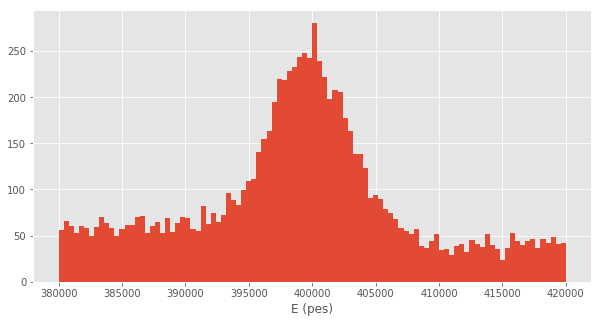

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(edf['e'], bins=nbins, range = (Emin,Emax));
plt.xlabel('E (pes)', fontsize=12);

## 2.3. Fitting photopeak

We perform a gaussian fit for the photopeak and assume a linear fit for background

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2} + m(E-E_{min}) + c$$

In [12]:
def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

In [13]:
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(edf['e']), np.std(edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                               bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

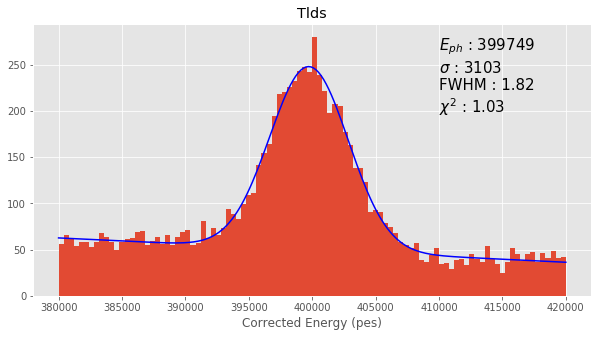

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(edf['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(410e3, 200, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(typo));

In [15]:
print('Extrapolated FWHM:',sig/Eph * 235 * (1592.5/2458)**.5)

Extrapolated FWHM: 1.4686350577019556


## 2.4. Searching correlations

### 2.4.1. Corrected Energy correlations (E vs All variables)

In [16]:
var = edf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

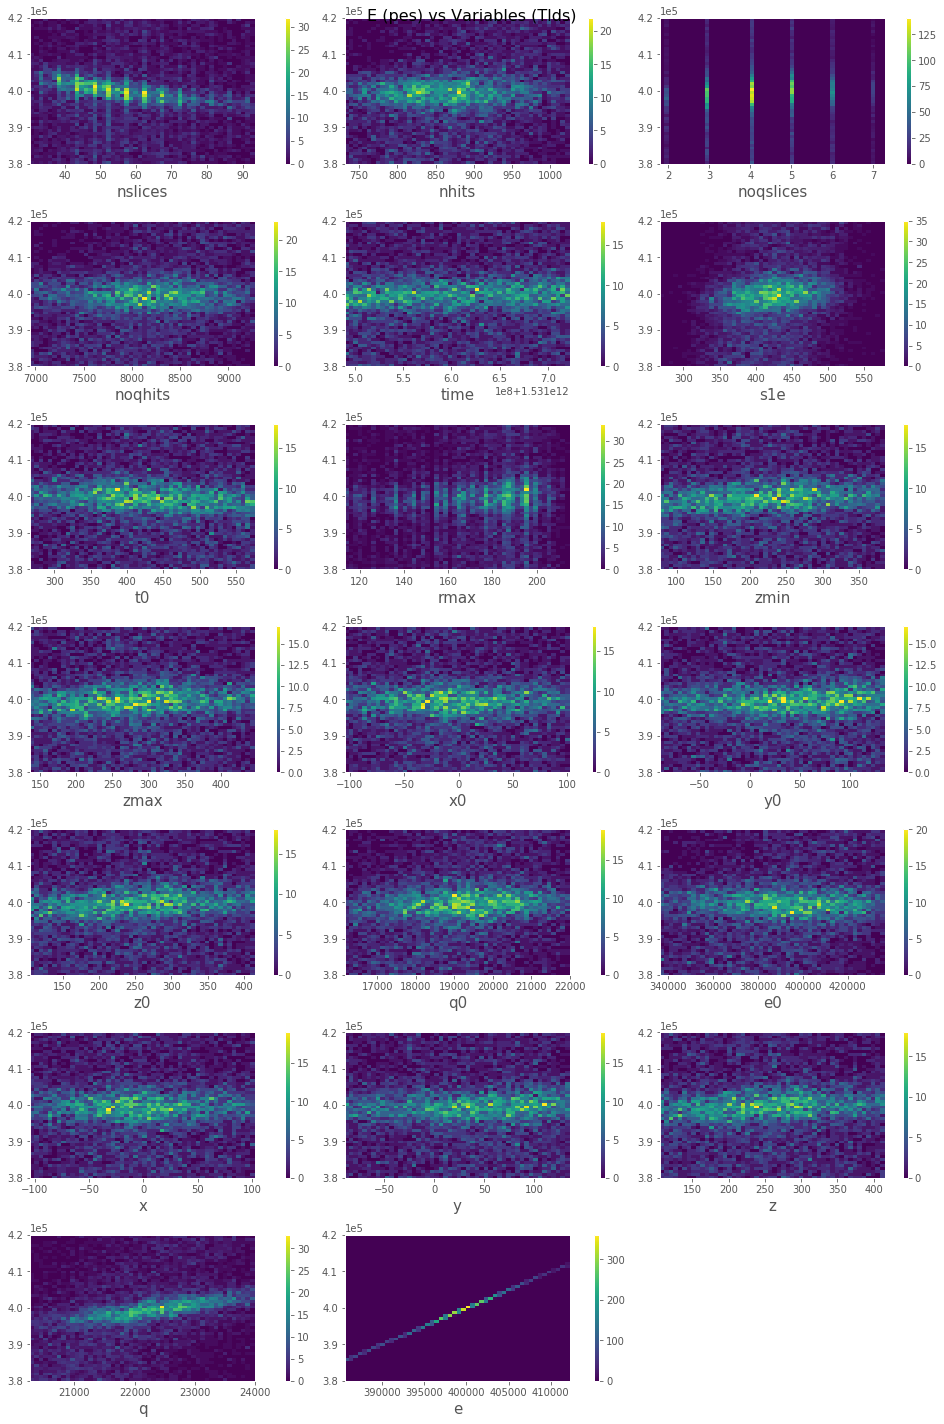

In [17]:
fig_e = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_e = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_e);

i=0
for v in var:
    axes    = f'ax_e{v}   = fig_e.add_subplot(gs_e[{i}])'
    exec(axes)
    hist       = (f'hist_e{v} = ax_e{v}.hist2d(edf["{v}"], edf["e"] ,bins=.5*nbins,' + 
                  f'range=((np.mean(edf["{v}"])-1.5*np.std(edf["{v}"]), np.mean(edf["{v}"])+1.5*np.std(edf["{v}"])), (Emin, Emax)))')
    exec(hist)
    labels     = (f'ax_e{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_e{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1
for v in var:
    cbars      = f'cbar_e{v} = fig_e.colorbar(hist_e{v}[3], ax = ax_e{v})'
    exec(cbars)
    fig_e.suptitle(f'E (pes) vs Variables ({typo})', fontsize=16);

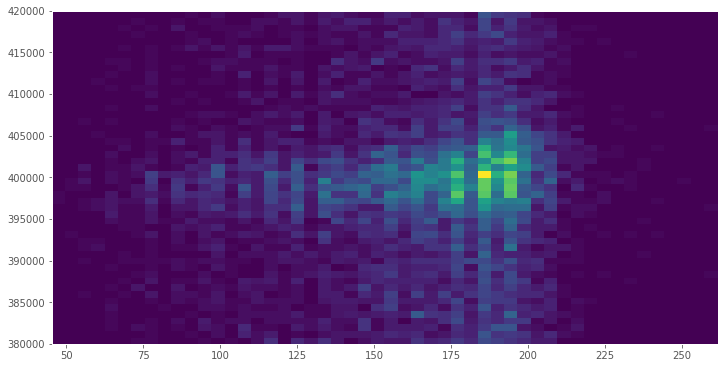

In [18]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(edf['rmax'], edf['e'], bins=.5*nbins);

### 2.4.2 E vs Number of Slices

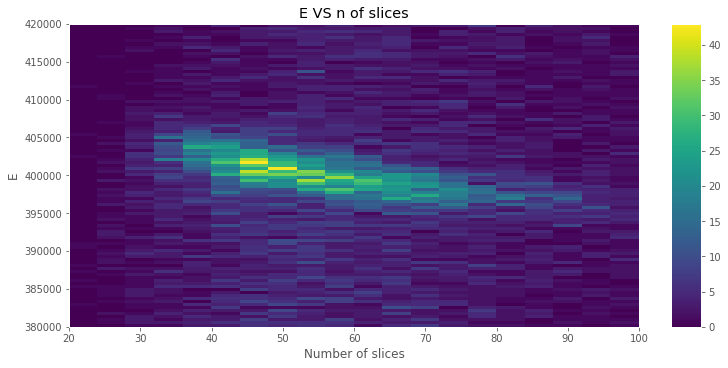

In [19]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, nbins], 
                                   range=((20, 100),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

In [20]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 10   #size of the group of slices to merge

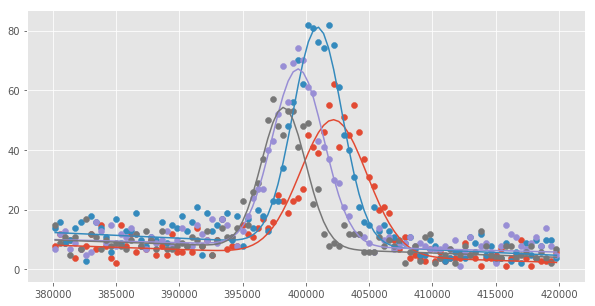

In [21]:
nslices_raw = np.unique(edf['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(edf[edf.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = edf[(edf.nslices >= nslices[0]) & ((edf.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                                   bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

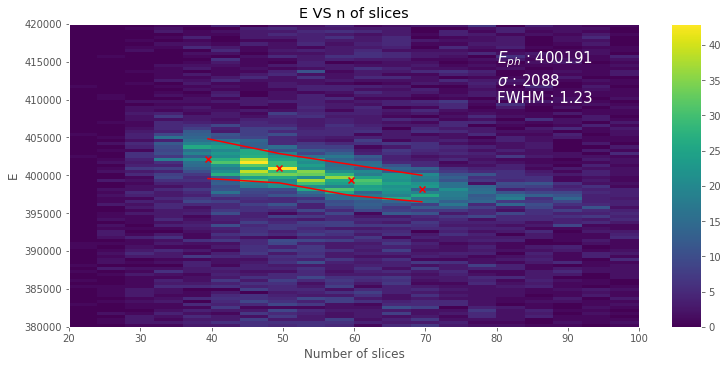

In [22]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, nbins], 
                                   range=((20, 100),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(80, 410e3, s = t, fontsize = 15, color='white');

In [23]:
profile

,nslices,Eph,sig,chisq
0,39.5,402194.868585,2625.388246,1.338558
1,49.5,400937.175198,1935.818589,1.616779
2,59.5,399385.609102,2044.730793,1.273644
3,69.5,398250.138389,1749.503894,1.168423


In [24]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [25]:
print('Extrapolated FWHM:', sig/Eph * 235 * (1592.5/2458)**.5)

Extrapolated FWHM: 0.9873194898088601


## 2.5. Fiducial cuts

### 2.5.1. Fit

In [26]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [27]:
fid_edf = edf[(edf.x0**2 + edf.y0**2 < R_fid**2) & (edf.z0 < z_fid_max) & (edf.z0 > z_fid_min)]

In [28]:
ydata, xdata = np.histogram(fid_edf['e'], bins=nbins, range=(Emin, Emax))
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(fid_edf['e']), np.std(fid_edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                               bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

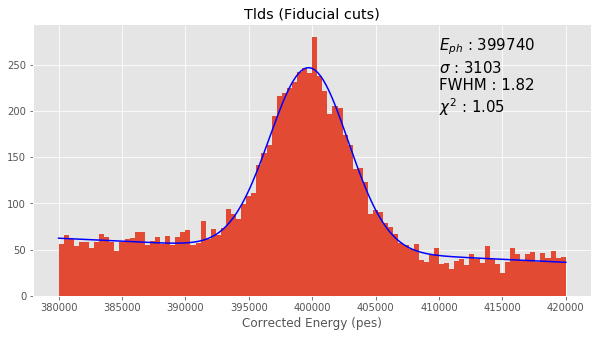

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(fid_edf['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(410e3, 200, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{} (Fiducial cuts)'.format(typo));

In [30]:
print('Extrapolated FWHM:',sig/Eph * 235 * (1592.5/2458)**.5)

Extrapolated FWHM: 1.4684604639036716


### 2.5.2. Number of slices profile

In [31]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 10   #size of the group of slices to merge

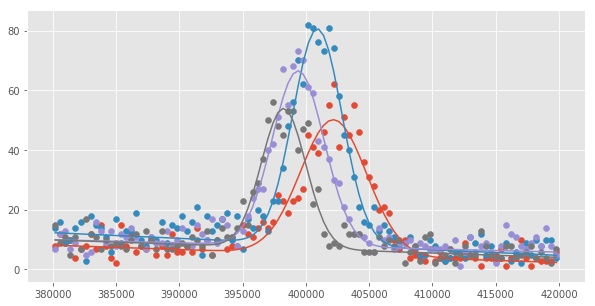

In [32]:
nslices_raw = np.unique(fid_edf['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(edf[edf.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = fid_edf[(fid_edf.nslices >= nslices[0]) & ((fid_edf.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                                   bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

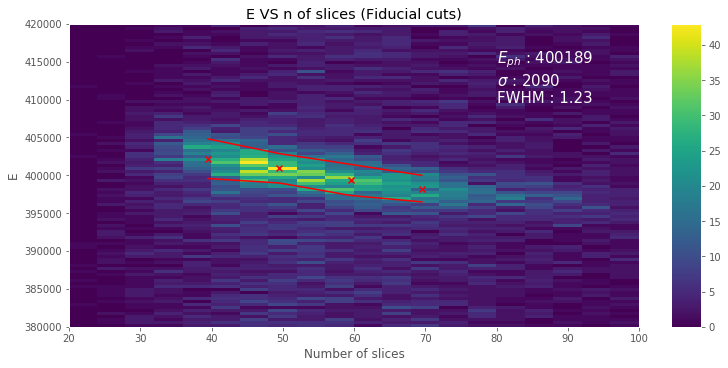

In [33]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, nbins], 
                                   range=((20, 100),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices (Fiducial cuts)');
cbar_enslices = fig_e.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(80, 410e3, s = t, fontsize = 15, color='white');

In [34]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [35]:
print('Extrapolated FWHM:', sig/Eph * 235 * (1592.5/2458)**.5)

Extrapolated FWHM: 0.9882126827876334


*------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

# 3. CHARGE

## 3.1. Overview

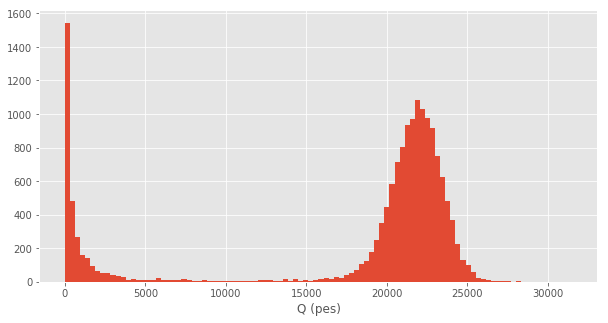

In [36]:
df['q'].hist(bins=nbins);
plt.xlabel('Q (pes)', fontsize=12);

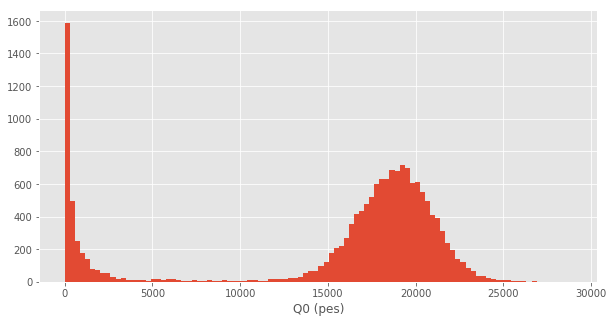

In [37]:
df['q0'].hist(bins=nbins);
plt.xlabel('Q0 (pes)', fontsize=12);

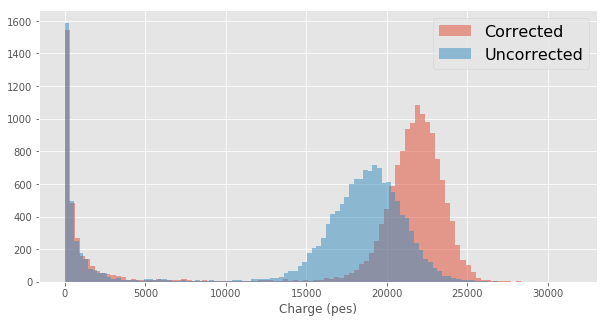

In [38]:
plt.hist(df['q'] , bins = nbins, alpha=.5, label='Corrected' );
plt.hist(df['q0'], bins = nbins, alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Charge (pes)', fontsize=12);

## 3.2. Select region

In [39]:
Qmax = 26e3
Qmin = 16e3

In [40]:
qdf = df[(df.q<Qmax) & (df.q>Qmin)]

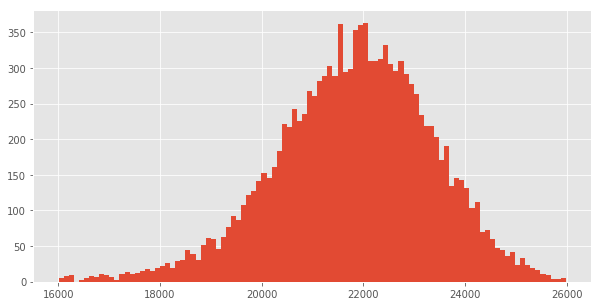

In [41]:
plt.hist(qdf['q'], bins=nbins);

## 3.3. Searching correlations

### 3.3.1. Corrected Charge correlations (Q vs All variables)

In [42]:
var = qdf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

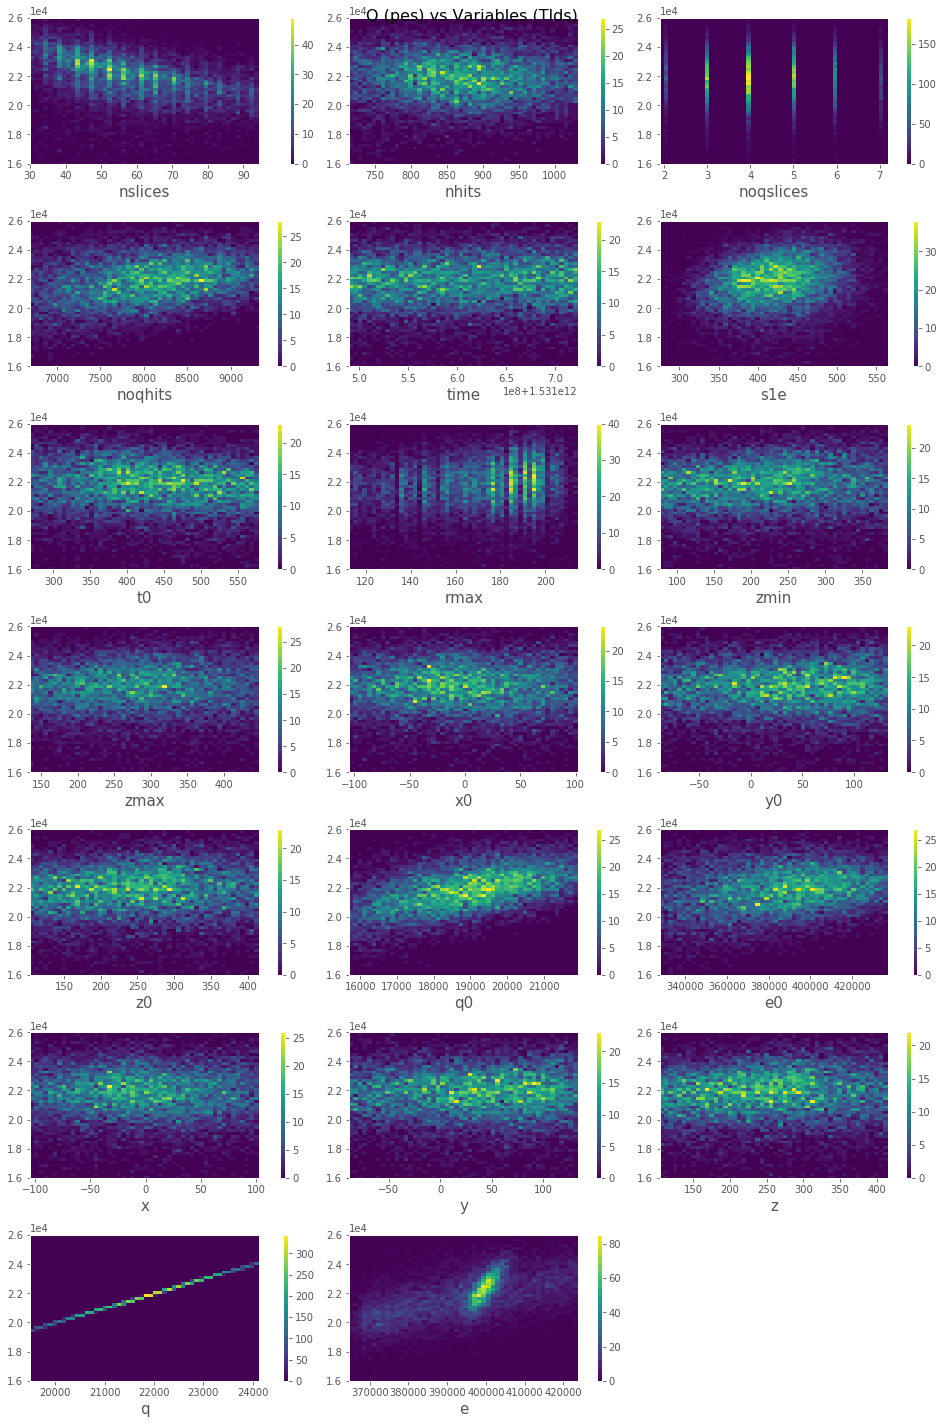

In [43]:
fig_q = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_q = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_q);

i=0
for v in var:
    axes    = f'ax_q{v}   = fig_q.add_subplot(gs_q[{i}])'
    exec(axes)
    hist       = (f'hist_q{v} = ax_q{v}.hist2d(qdf["{v}"], qdf["q"] ,bins=.5*nbins,' + 
                  f'range=((np.mean(qdf["{v}"])-1.5*np.std(qdf["{v}"]), np.mean(qdf["{v}"])+1.5*np.std(qdf["{v}"])), (Qmin, Qmax)))')
    exec(hist)
    labels     = (f'ax_q{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_q{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1

for v in var:
    cbars      = f'cbar_q{v} = fig_q.colorbar(hist_q{v}[3], ax = ax_q{v})'
    exec(cbars)
fig_q.suptitle(f'Q (pes) vs Variables ({typo})', fontsize=16);

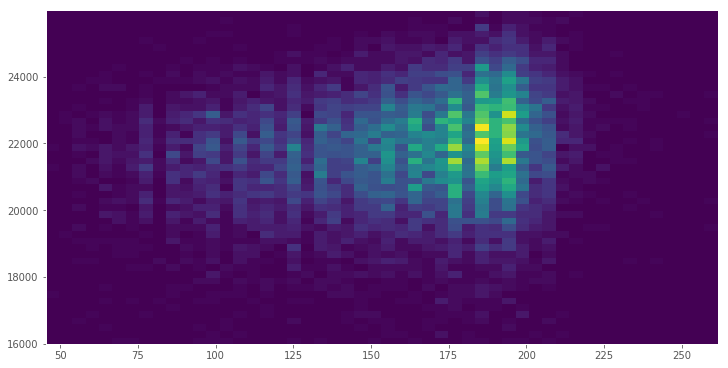

In [44]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(qdf['rmax'], qdf['q'], bins=.5*nbins);

### 3.4.2 Q vs Number of Slices

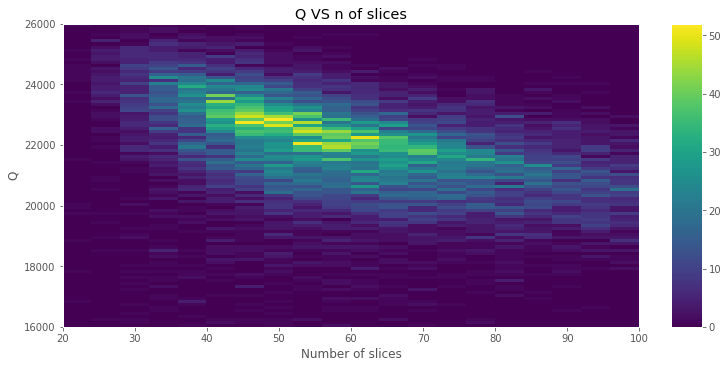

In [45]:
fig_qnslices = plt.figure(constrained_layout=True)

gs_qnslices = gridspec.GridSpec(1, 1, figure=fig_qnslices)

ax_qnslices = fig_qnslices.add_subplot(gs_qnslices[0, 0])
hist_qnslices = ax_qnslices.hist2d(qdf['nslices'], qdf['q'] , bins=[.2*nbins, nbins],
                                   range=((20, 100),(Qmin, Qmax)));
ax_qnslices.set_xlabel('Number of slices');
ax_qnslices.set_ylabel('Q');
ax_qnslices.set_title('Q VS n of slices');
cbar_qnslices = fig_qnslices.colorbar(hist_qnslices[3], ax = ax_qnslices)

## 3.5. Fiducial cuts

### 3.5.1. Q vs Number of slices

In [46]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [47]:
fid_qdf = qdf[(qdf.x0**2 + qdf.y0**2 < R_fid**2) & (qdf.z0 < z_fid_max) & (qdf.z0 > z_fid_min)]

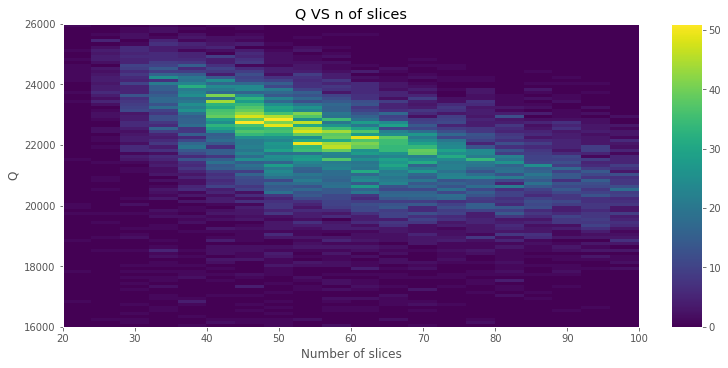

In [48]:
fig_qnslices = plt.figure(constrained_layout=True)

gs_qnslices = gridspec.GridSpec(1, 1, figure=fig_qnslices)

ax_qnslices = fig_qnslices.add_subplot(gs_qnslices[0, 0])
hist_qnslices = ax_qnslices.hist2d(fid_qdf['nslices'], fid_qdf['q'] , bins=[.2*nbins, nbins],
                                   range=((20, 100),(Qmin, Qmax)));
ax_qnslices.set_xlabel('Number of slices');
ax_qnslices.set_ylabel('Q');
ax_qnslices.set_title('Q VS n of slices');
cbar_qnslices = fig_qnslices.colorbar(hist_qnslices[3], ax = ax_qnslices)

*------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

# 4. Energy/Charge

## 4.1. Photopeak selection and histogram

In [5]:
Emax = 420e3
Emin = 380e3

Qmax = 26e3
Qmin = 16e3

eqdf = df[(df.e<Emax)&(df.e>Emin)&(df.q<Qmax)&(df.q>Qmin)]

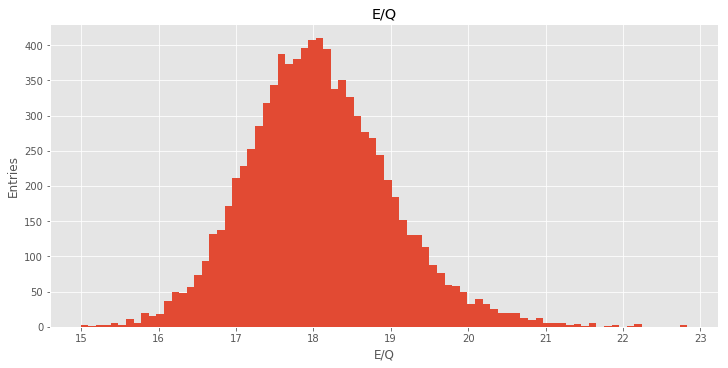

In [7]:
fig_eq = plt.figure(constrained_layout=True)

gs_eq = gridspec.GridSpec(1, 1, figure=fig_eq)

ax_hist = fig_eq.add_subplot(gs_eq[0])
hist_eq = ax_hist.hist(eqdf['e']/eqdf['q'], bins=int(.8*nbins));
ax_hist.set_xlabel('E/Q');
ax_hist.set_ylabel('Entries');
ax_hist.set_title('E/Q');

## 4.2. Correlations (E/Q vs all variables)

In [8]:
var = eqdf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

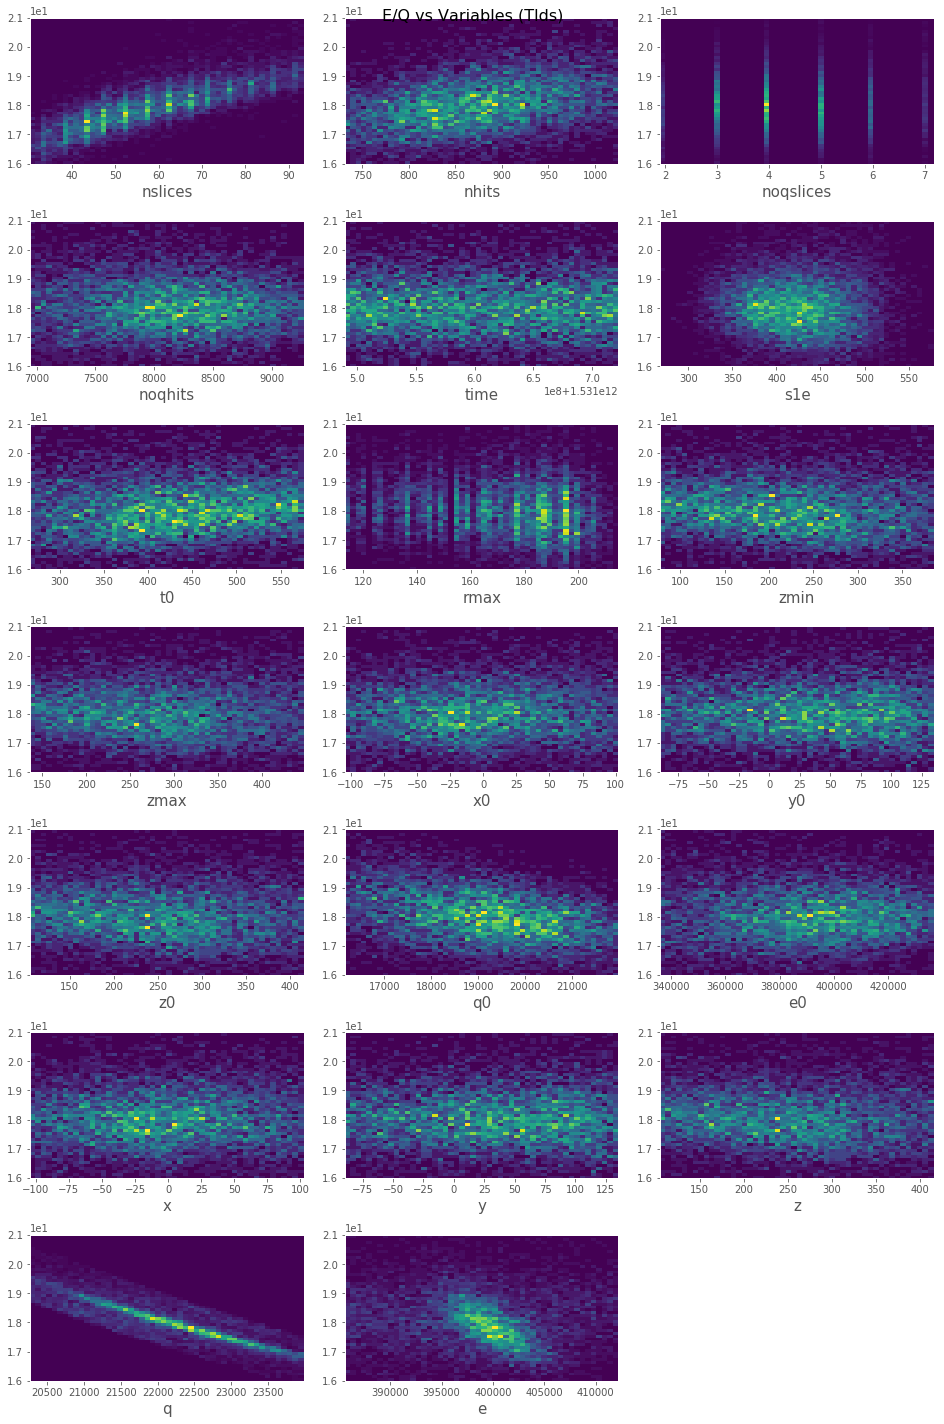

In [9]:
fig_eq = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_eq = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_eq);

i=0
for v in var:
    axes    = f'ax_eq{v}   = fig_eq.add_subplot(gs_eq[{i}])'
    exec(axes)
    hist       = (f'hist_eq{v} = ax_eq{v}.hist2d(eqdf["{v}"], eqdf["e"]/eqdf["q"] ,bins=.5*nbins,' +
                  f'range=((np.mean(eqdf["{v}"])-1.5*np.std(eqdf["{v}"]), np.mean(eqdf["{v}"])+1.5*np.std(eqdf["{v}"])), (16, 21)))')
    exec(hist)
    labels     = (f'ax_eq{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_eq{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1

#for v in var:
#    cbars      = f'cbar_eq{v} = fig_eq.colorbar(hist_eq{v}[3], ax = ax_eq{v})'
#    exec(cbars)
fig_eq.suptitle(f'E/Q vs Variables ({typo})', fontsize=16);

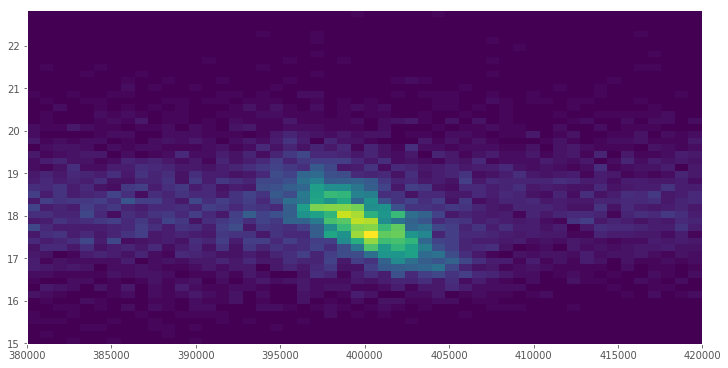

In [10]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(eqdf['e'], eqdf['e']/eqdf['q'], bins=.5*nbins);

### 3.4.2 E/Q vs Number of Slices

In [ ]:
fig_eqc = plt.figure(constrained_layout=True)

gs_eqc = gridspec.GridSpec(2, 2, figure=fig_eqc)

ax_eqnsl = fig_eqc.add_subplot(gs_eqc[0, 0:2])
hist_eqnsl = ax_eqnsl.hist2d(eqdf['nslices'], eqdf['e']/eqdf['q'], bins=[.2*nbins, nbins], 
                                    range=((50, 150),(16, 21)));
ax_eqnsl.set_xlabel('Number of slices');
ax_eqnsl.set_ylabel('E/Q');
ax_eqnsl.set_title('E/Q VS n of slices');
cbar_eqnsl = fig_eqc.colorbar(hist_eqnsl[3], ax = ax_eqnsl)

ax_eqe = fig_eqc.add_subplot(gs_eqc[1, 0])
hist_eqe = ax_eqe.hist2d(eqdf['e'], eqdf['e']/eqdf['q'], bins=[nbins, nbins], 
                                    range=((Emin, Emax),(16, 21)));
ax_eqe.set_xlabel('E');
ax_eqe.set_ylabel('E/Q');
ax_eqe.set_title('E/Q VS E');
cbar_eqe = fig_eqc.colorbar(hist_eqe[3], ax = ax_eqe)

ax_eqq = fig_eqc.add_subplot(gs_eqc[1, 1])
hist_eqq = ax_eqq.hist2d(eqdf['q'], eqdf['e']/eqdf['q'], bins=[nbins, nbins], 
                                    range=((Qmin, Qmax),(16, 21)));
ax_eqq.set_xlabel('Q');
ax_eqq.set_ylabel('E/Q');
ax_eqq.set_title('E/Q VS Q');
cbar_eqq = fig_eqc.colorbar(hist_eqq[3], ax = ax_eqq)